In [13]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from numpy import array
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")


df = pd.read_csv("dataset.csv")
sub = pd.read_excel("Round1a_Submission_Template.xlsx")
F = pd.read_excel("ready.xlsx")
df = df[df['City'] == 'Chandigarh']
df.dropna()
df['PM2.5'].mean()

133.24727769523508

Text(0, 0.5, 'PM2.5_Prediction')

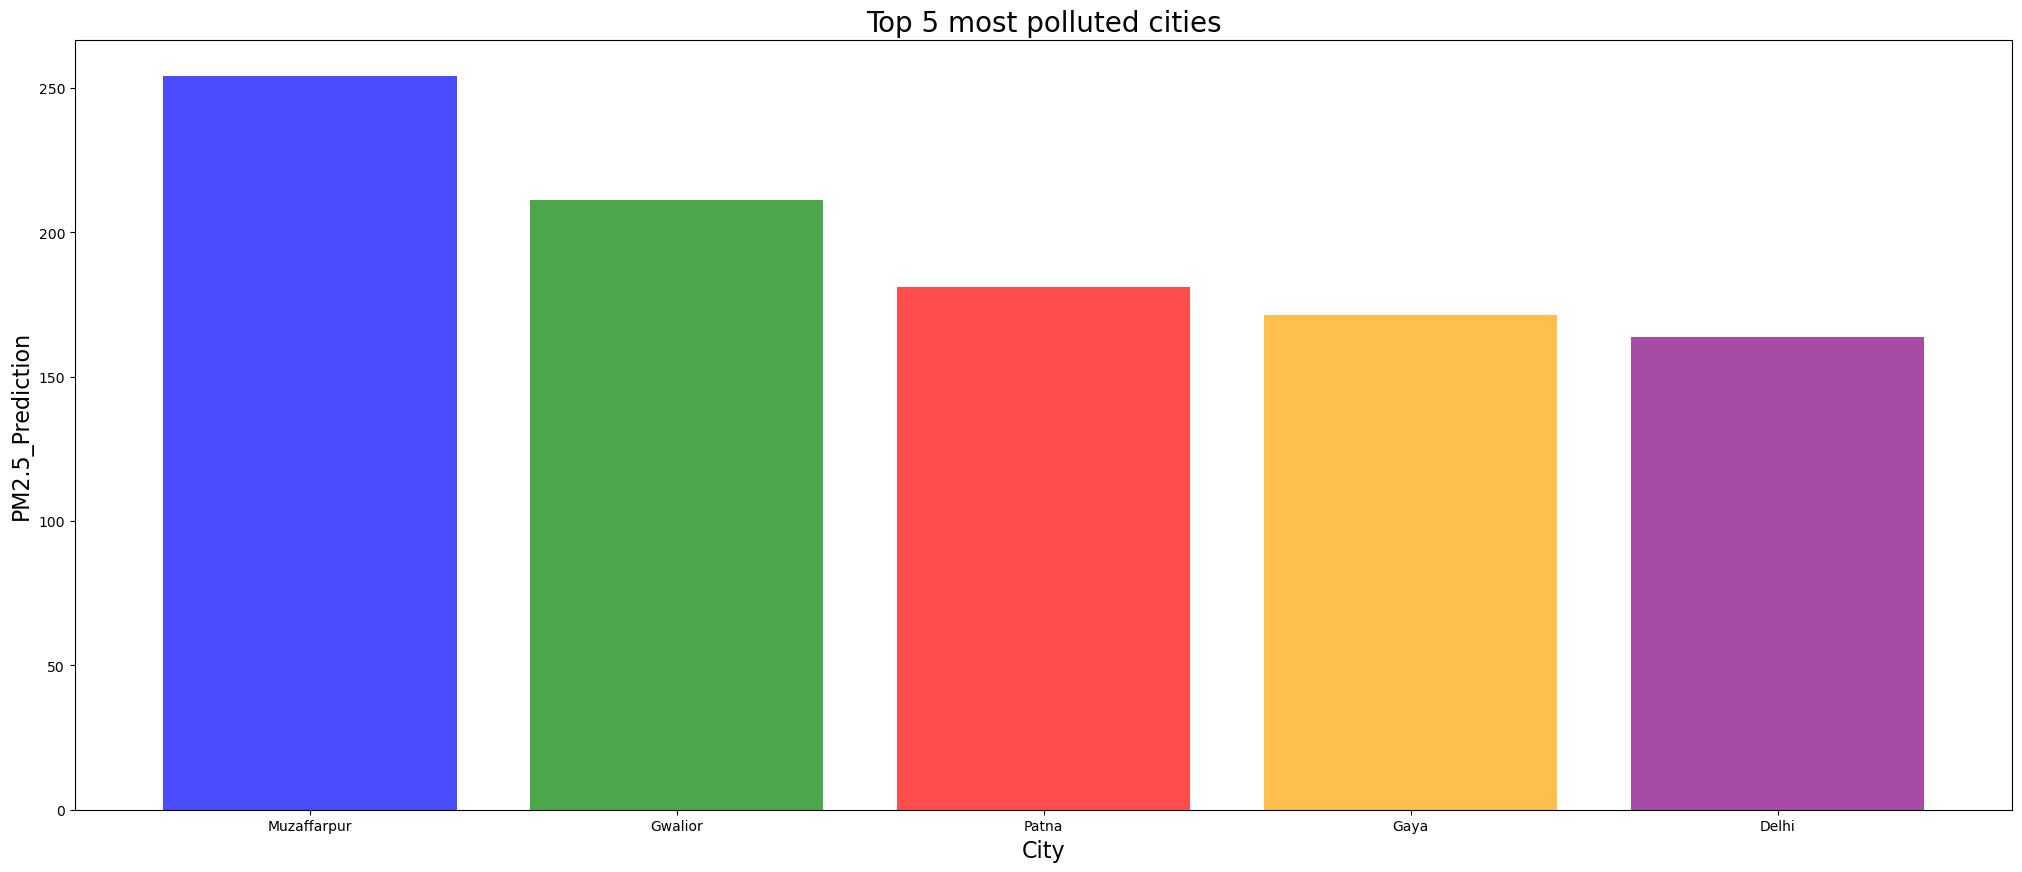

In [23]:
plt.figure(figsize=(25 , 10))
Y = 'PM2.5_Prediction'
ind = F[[Y, 'City']].groupby('City', as_index=False).mean().sort_values(by=Y,ascending=False)
plt.title("Top 5 most polluted cities" , fontsize = 20)
colors = ['blue', 'green', 'red', 'orange', 'purple']
plt.bar(ind['City'][:5] , ind[Y][:5] , color = colors , alpha = 0.7)
plt.xlabel('City' , fontsize=16)
plt.ylabel(Y , fontsize=16)


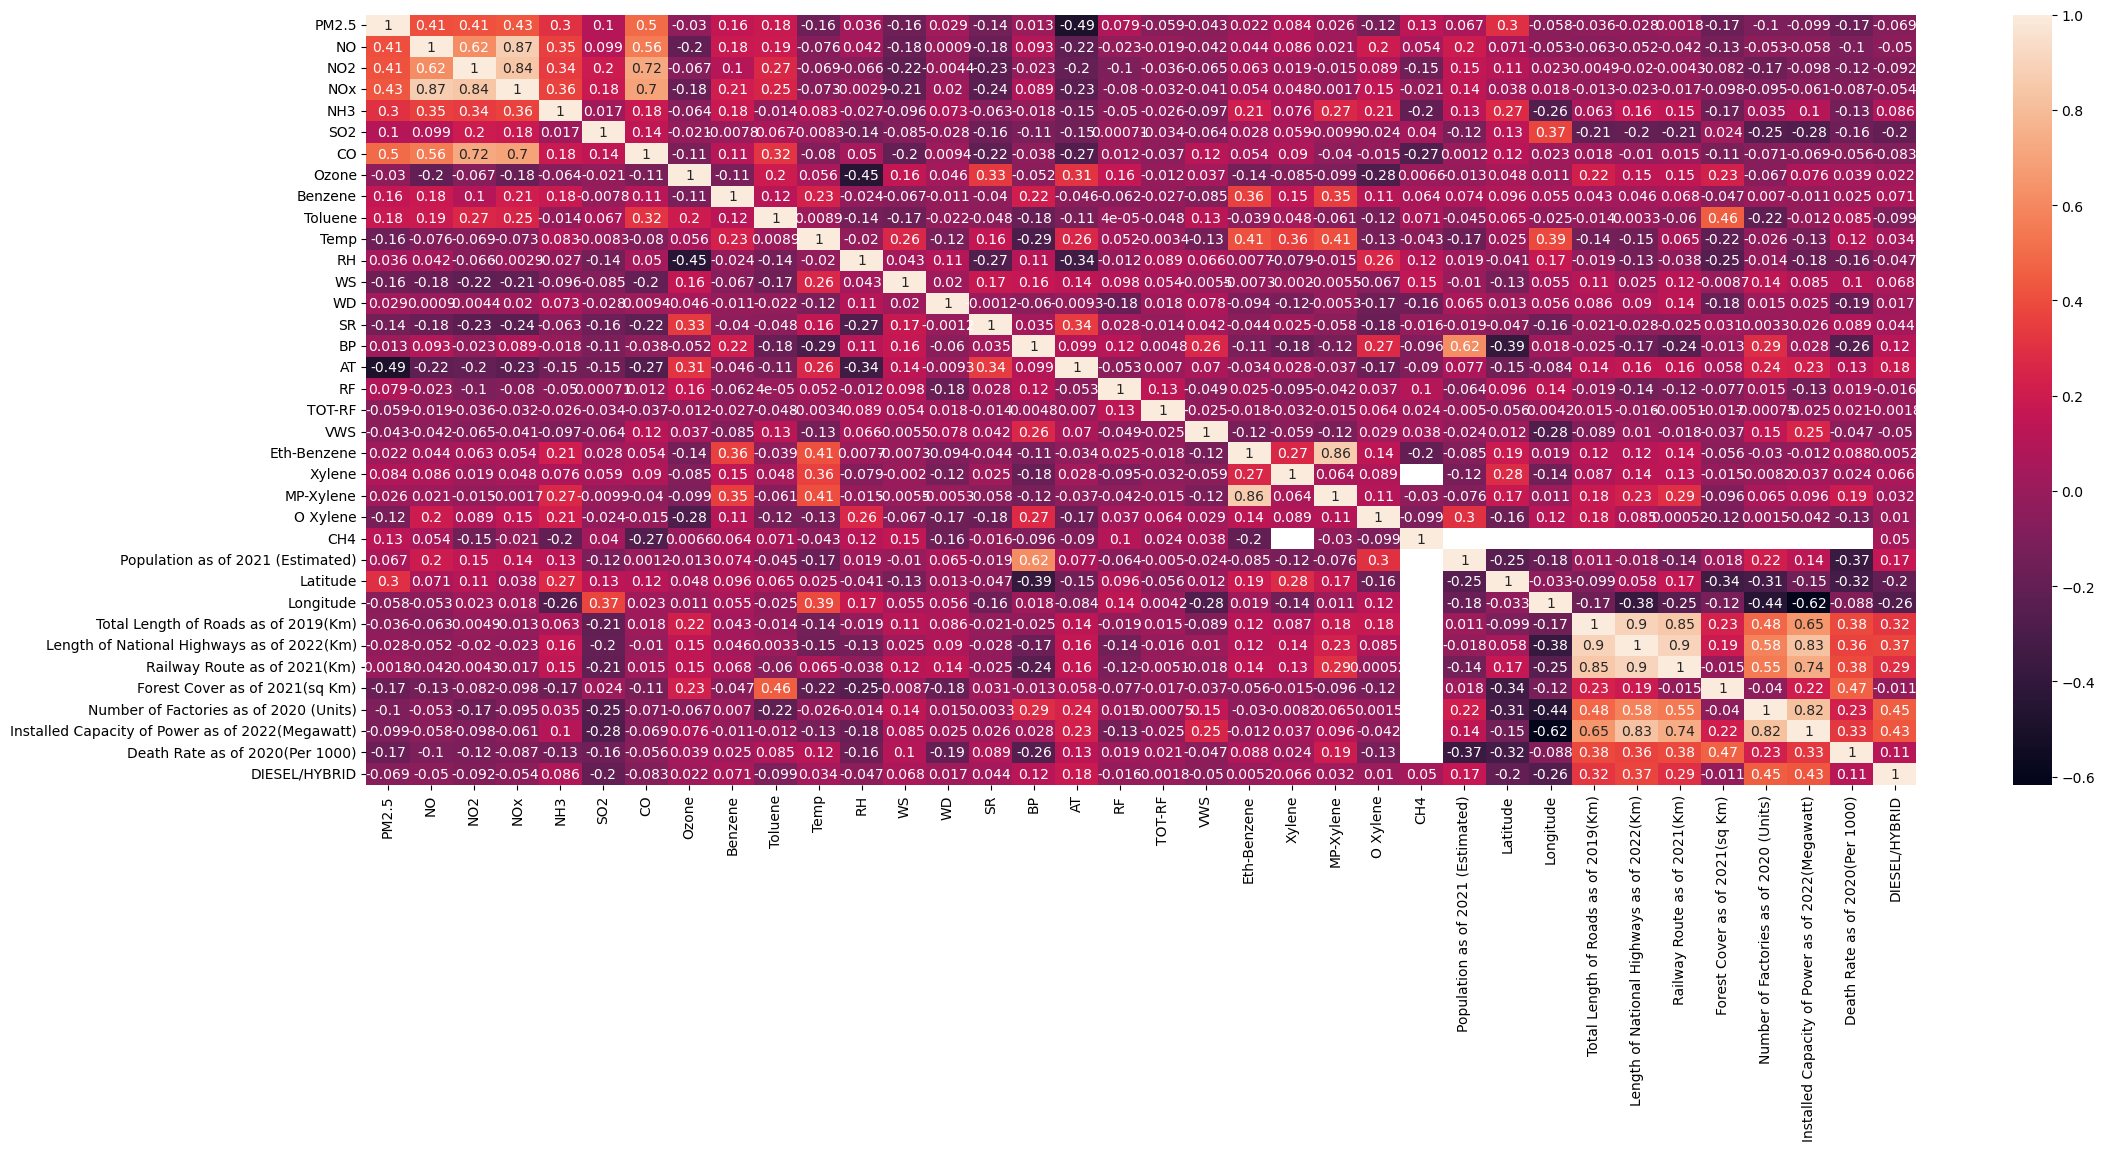

In [141]:
plt.figure(figsize=(25 ,10))
cor = df.corr()
sns.heatmap(cor , annot=True)
plt.show()

In [142]:
df = df[['PM2.5' , "City" , "Time Periods" ]]
df.reset_index(drop=True)

,PM2.5,City,Time Periods
0,549.256878,Delhi,2020-01-01 00:00
1,435.438303,Delhi,2020-01-01 04:00
2,453.312378,Delhi,2020-01-01 08:00
3,186.603123,Delhi,2020-01-01 12:00
4,262.616309,Delhi,2020-01-01 16:00
...,...,...,...
223579,196.989121,Mumbai,2022-12-31 04:00
223580,187.428487,Mumbai,2022-12-31 08:00
223581,176.635690,Mumbai,2022-12-31 12:00
223582,189.740021,Mumbai,2022-12-31 16:00


In [143]:
df.isna().sum()

PM2.5           5540
City               0
Time Periods       0
dtype: int64

In [144]:
df.describe()['PM2.5']

count    218044.000000
mean         69.213957
std          56.962718
min           0.100000
25%          30.340937
50%          51.630955
75%          91.310000
max         890.873920
Name: PM2.5, dtype: float64

## ARIMA


In [145]:
def ARIMA(get):
    
    print(data.head(5))

        # check stationarity
        # adfuller_test(data['PM2.5'].dropna())

    stepwise_fit = auto_arima(data['PM2.5'].dropna() , trace=True,suppress_warnings=True)

    stepwise_fit.summary()


    plt.suptitle(x)
    plt.plot(data['PM2.5'])
    plt.show()

    sz = (int)(0.8 * len(data))
    train = data.iloc[:sz]
    test = data.iloc[sz:]

    model = sm.tsa.arima.ARIMA(train['PM2.5'],order=(5,1,5))
    model = model.fit()


    s = len(train)
    e = len(train) + len(test) - 1
    pred = model.predict(start=s,end=e,typ='levels')
    pred.index=data.index[s:e+1]

    pred.plot(legend=True,figsize=(12,5))
    test['PM2.5'].plot(legend=True,figsize=(12,5))
    plt.show()
    t = 1

## LSTM

In [146]:
def create_dataset(dataset , timestep):
    dataX , dataY = [] , []
    for i in range(len(dataset) - timestep - 1):
        a = dataset[i:(i + timestep),0]
        dataX.append(a)
        dataY.append(dataset[i+timestep , 0])
    
    return np.array(dataX) , np.array(dataY)

In [147]:
def lstm(data , city):
        df1 = data[['PM2.5']]
        df1.shape
        df1

        scaler = MinMaxScaler(feature_range=(0,1))
        df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

        train_size = int(len(df1) * 0.8)
        test_size = len(df1) - train_size
        train_data,test_data = df1[:train_size,:] , df1[train_size: ,:]
        train_data

        timestep = 10
        X_train , Y_train = create_dataset(train_data,timestep)
        X_test,Y_test = create_dataset(test_data,timestep)
        X_test.shape , Y_test.shape

        X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
        X_test = X_test.reshape(X_test.shape[0] , X_test.shape[1] , 1)
       
        model = Sequential()
        model.add(LSTM(50 , return_sequences=True,input_shape=(10 ,1)))
        model.add(LSTM(50 , return_sequences=True))
        model.add(LSTM(50))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
        model.summary()
        model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=64,verbose=1)

        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)
        train_predict = scaler.inverse_transform(train_predict)
        test_predict = scaler.inverse_transform(test_predict)

        print(math.sqrt(mean_squared_error(Y_train,train_predict)))
        print(math.sqrt(mean_squared_error(Y_test,test_predict)))

        look_back=10
        trainPredictPlot = np.empty_like(df1)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
        # shift test predictions for plotting
        testPredictPlot = np.empty_like(df1)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
        # plot baseline and predictions

        xaxis = data['Time Periods']

        plt.figure(figsize=(15,5))
        plt.plot(xaxis , scaler.inverse_transform(df1))
        plt.plot(xaxis , trainPredictPlot)
        plt.plot(xaxis , testPredictPlot)
        plt.legend(['Actual' , 'test prediction' , 'train prediction'])
        plt.xlabel('Dates')
        plt.ylabel('PM2.5')
        plt.show()

        x_input = test_data[len(test_data) - timestep:].reshape(1,-1)
        x_input.shape 
        temp_input = list(x_input)
        temp_input = temp_input[0].tolist()


        lst_output=[]
        n_steps=10
        i=0
        hours = ['']
        while(i<18):
                if(len(temp_input)>n_steps):
                        #print(temp_input)
                        x_input=np.array(temp_input[1:])
                        print("{} day input {}".format(i,x_input))
                        x_input=x_input.reshape(1,-1)
                        x_input = x_input.reshape((1, n_steps, 1))
                        #print(x_input)
                        yhat = model.predict(x_input, verbose=0)
                        print("{} day output {}".format(i,yhat))
                        temp_input.extend(yhat[0].tolist())
                        temp_input=temp_input[1:]
                        #print(temp_input)
                        lst_output.extend(yhat.tolist())
                        i=i+1
                else:
                        x_input = x_input.reshape((1, n_steps,1))
                        yhat = model.predict(x_input, verbose=0)
                        print(yhat[0])
                        temp_input.extend(yhat[0].tolist())
                        print(len(temp_input))
                        lst_output.extend(yhat.tolist())
                        i=i+1
    

        
        print(lst_output)

        day_new = np.arange(1,1 + n_steps)
        day_pred = np.arange(1+n_steps,1+n_steps+18)

        df3 = df1.tolist()
        df3.extend(lst_output)

        plt.figure(figsize=(15,5)).suptitle(city)
        plt.plot(day_new,scaler.inverse_transform(df1[-10:]))
        plt.plot(day_pred,scaler.inverse_transform(lst_output))
        plt.xlabel('Dates')
        plt.ylabel('PM2.5')
        plt.show()

        lst_output = scaler.inverse_transform(lst_output)

        return lst_output

        
    

In [148]:
from scipy.stats import norm

In [149]:
def detect_outlier(data):

    thre = 3
    mean = np.mean(data['PM2.5'])
    std = np.std(data['PM2.5'])
    outlier = []
    for i in data['PM2.5']:
        z_score = (i - std) / mean
        if np.abs(z_score) > thre:
            outlier.append(i)


    return outlier


In [150]:
# final = []
count = 0
idx = 0
for x in df['City'].unique():
    
    if count > 0:
        break
    
    count += 1
    data = df[df['City'] == x]
    data = data[['PM2.5' , 'Time Periods']]
    data = data.interpolate()
    data = data.fillna(0)
    data['Time Periods']  = pd.to_datetime(data['Time Periods'])
    data.set_index(data['Time Periods'] , inplace=True)  

    outliers = detect_outlier(data)
    data = data[data['PM2.5'].isin(outliers) == False]

    data.reset_index(drop = True , inplace=True)
    # print(data)
    # print(data.describe())
    # plt.figure(figsize=(15,5))
    # plt.plot(data['PM2.5'])
    # rng = np.arange(data['PM2.5'].min() , data['PM2.5'].max() ,1)
    # # plt.plot(rng , norm.pdf(rng , data['PM2.5'].mean() , data['PM2.5'].std()))
    # plt.show()
    final = lstm(data , x)
    # for i in final:
    #     sub['PM2.5_Prediction'][idx] = np.round(i,2)
    #     idx += 1
    
    


    

# print(final) 
# sub
# sub.to_excel('ready.xlsx')

            
        

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_52 (LSTM)              (None, 10, 50)            20200     
                                                                 
 lstm_53 (LSTM)              (None, 50)                20200     
                                                                 
 dense_17 (Dense)            (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
82/82 [==============================] - 19s 85ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 2/10
82/82 [=

KeyboardInterrupt: 